<a href="https://colab.research.google.com/github/nilanjanap/Machine-Learning/blob/master/alzheimer_disease_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv3D, Dense, Dropout, Flatten, InputLayer, Lambda, MaxPool2D, MaxPooling3D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Hyperparameters and Settings**

In [ ]:
size_ResNet50 = (224,224,3)
size_VGG19 = (224,224,3)
size_IncpV3 = (299,299,3)
BATCH_size = 32
OPT = Adam(learning_rate=0.001) #Adam, SGD, RMSprop, 
LOSS_func = tf.keras.losses.CategoricalCrossentropy() # 
EPOCHS = 20
METRICS = [
      #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
      #'acc',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
weight_decay = 0.001

#Data Augmentation/ Dataset splitting

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.1)
test_datagen  = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.1
                                  )
test_datagen  = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.1
                                  )

#Load in the data


In [ ]:
input_size = (224,224)
#input_size = (299,299)

images_train = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/publications/Alzheimer_s Dataset/train',
                                                target_size = input_size, 
                                                class_mode = 'categorical',
                                                subset = 'training',
                                                batch_size=BATCH_size)

images_validation = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/publications/Alzheimer_s Dataset/train',
                                                target_size = input_size,
                                                class_mode = 'categorical',
                                                subset = 'validation',
                                                batch_size=BATCH_size)

images_test = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/publications/Alzheimer_s Dataset/test',
                                                target_size = input_size,
                                                class_mode = 'categorical',
                                                #subset = 'testing'
                                                batch_size=BATCH_size)


Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## **Getting started**

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
import matplotlib.image as mpimg
import random

**Data Exploration**

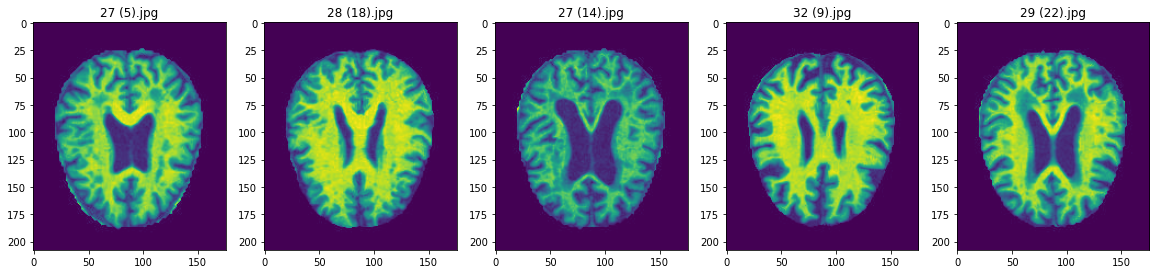

In [ ]:
plt.figure(figsize=(20,20))
test_folder="/content/drive/MyDrive/publications/Alzheimer_s Dataset/test/MildDemented" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

**Moderate Demented**

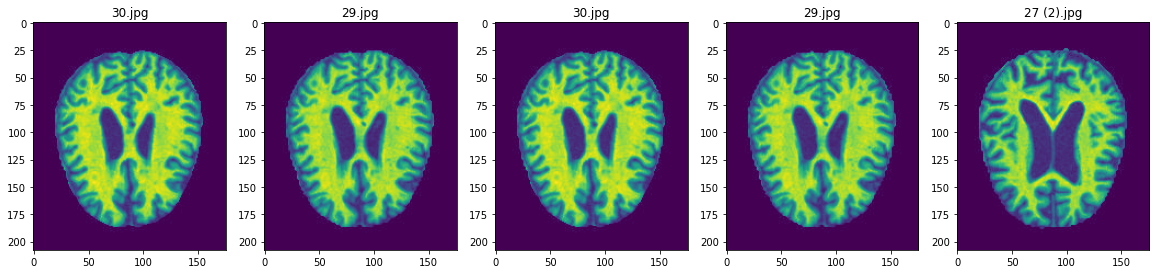

In [ ]:
plt.figure(figsize=(20,20))
test_folder="/content/drive/MyDrive/publications/Alzheimer_s Dataset/test/ModerateDemented" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

**Non Demented**

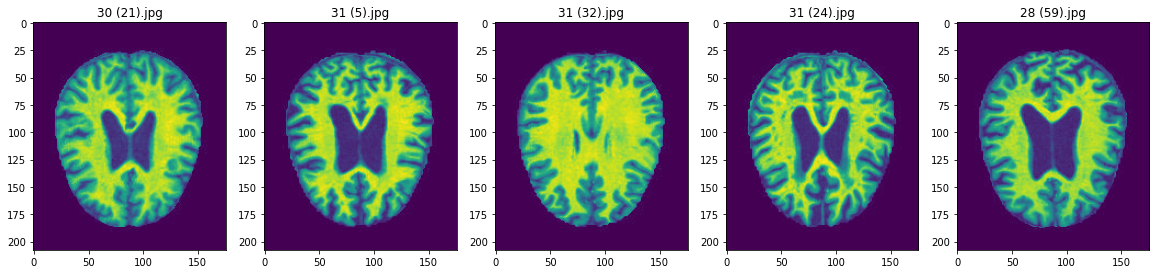

In [ ]:
plt.figure(figsize=(20,20))
test_folder="/content/drive/MyDrive/publications/Alzheimer_s Dataset/test/NonDemented" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

**Very Mild Demented**

---



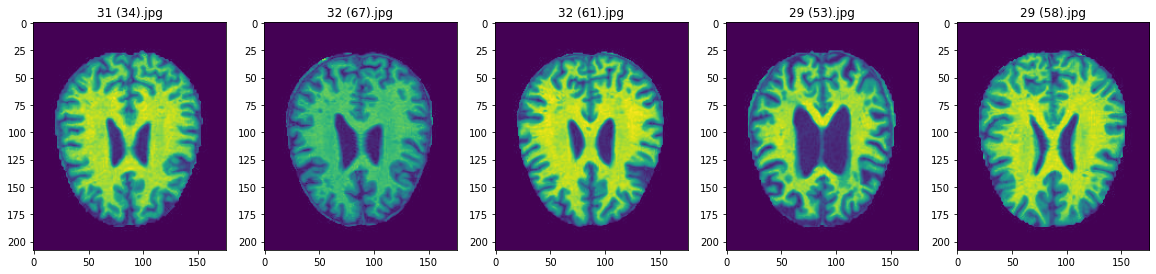

In [ ]:
plt.figure(figsize=(20,20))
test_folder="/content/drive/MyDrive/publications/Alzheimer_s Dataset/test/VeryMildDemented" 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# **Transfer Learning Pre-Trained Model (2D CNNs)**

In [ ]:
base_model = VGG19(input_shape=size_VGG19, include_top=False, weights="imagenet")

80142336/80134624 [==============================] - 1s 0us/step


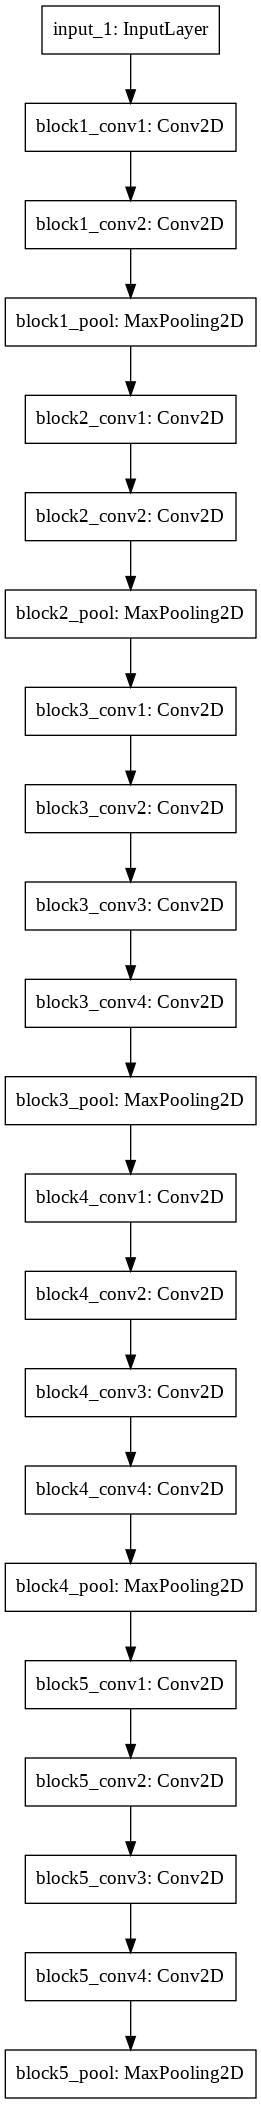

In [ ]:
#base_model = InceptionV3(input_shape=size_IncpV3, include_top=False, weights='imagenet')

#base_model = ResNet50(input_shape=size_ResNet50, include_top=False, weights='imagenet')
#Freezing the top layers (pre-trained model)
for each_layer in base_model.layers:
    each_layer.trainable = False
plot_model(base_model) 

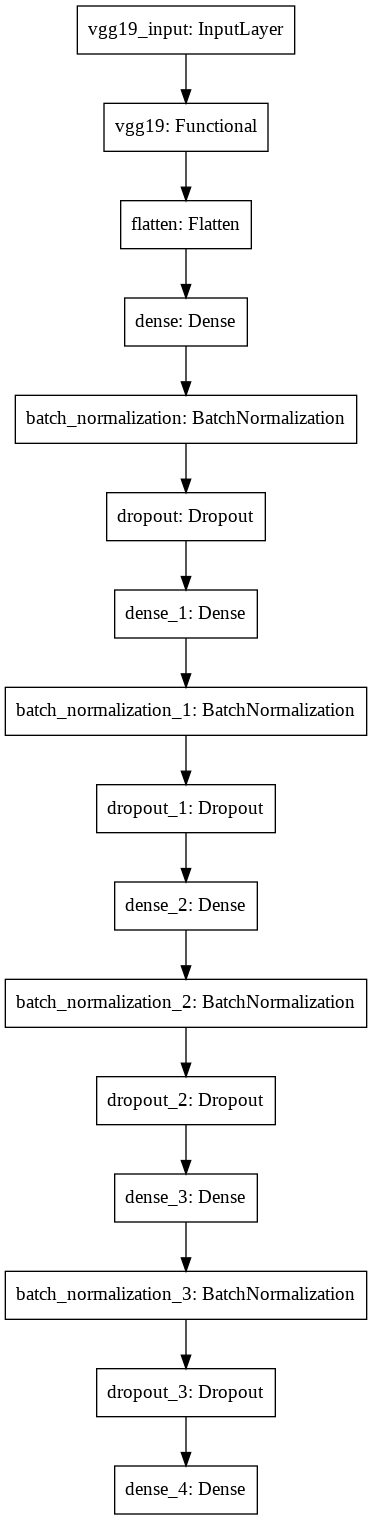

In [ ]:
# Building Model (v3)

model = Sequential()

#model.add(Lambda(lambda image: tf.image.resize(image, input_size)))
model.add(base_model)

model.add(Flatten())

"""
model.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay), 
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay), 
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
"""
"""
model.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
"""
model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(weight_decay),
                kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
        #model.add(Lambda(lambda x: tf.abs(x)))
        #model.add(LSTM(256))
        #model.add(LSTM(128))
model.add(Dense(4, activation='softmax'))
plot_model(model)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

## **Model (3D CNNs)**

In [ ]:
"""
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='softmax'))
"""

"\nmodel = Sequential()\n\nmodel.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))\nmodel.add(MaxPooling3D(pool_size=(2, 2, 2)))\nmodel.add(BatchNormalization(center=True, scale=True))\nmodel.add(Dropout(0.5))\nmodel.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))\nmodel.add(MaxPooling3D(pool_size=(2, 2, 2)))\nmodel.add(BatchNormalization(center=True, scale=True))\nmodel.add(Dropout(0.5))\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))\nmodel.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))\nmodel.add(Dense(5, activation='softmax'))\n"